# Word Embedding for Hebrew Language

Word2Vec is a popular algshnayimthm used for generating dense vector representations of words (called embedding) in large corpora using unsupervised learning. The resulting vectors have been shown to capture semantic relationships between the corresponding words and are used extensively for many downstream natural language processing (NLP) tasks like sentiment analysis, named entity recognition and machine translation.

SageMaker BlazingText which provides efficient implementations of Word2Vec on

- single CPU instance
- single instance with multiple GPUs - P2 or P3 instances
- multiple CPU instances (Distributed training)

In this notebook, we demonstrate how BlazingText can be used for distributed training of word2vec using multiple CPU instances.

## Step 1: Getting a large corpus of text in Hebrew

### Data Ingestion

We will use the latest Hebrew Wikipedia dump, which at the time of writing can be found here: https://dumps.wikimedia.org/hewiki/latest/. For the algshnayimthm to work we will need large amounts of plain text. For that purpose, we can just download the main `...pages-articles...` file. Files and formats in the dump are explained here: https://meta.wikimedia.org/wiki/Data_dumps/Dump_format

In [1]:
!wget https://dumps.wikimedia.org/hewiki/latest/hewiki-latest-pages-articles-multistream.xml.bz2

--2020-05-27 11:31:28--  https://dumps.wikimedia.org/hewiki/latest/hewiki-latest-pages-articles-multistream.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 679046659 (648M) [application/octet-stream]
Saving to: ‘hewiki-latest-pages-articles-multistream.xml.bz2’

hewiki-latest-pages 100%[===================>] 647.59M  4.47MB/s    in 2m 16s  

2020-05-27 11:33:44 (4.77 MB/s) - ‘hewiki-latest-pages-articles-multistream.xml.bz2’ saved [679046659/679046659]



This archive contains rich markup and lots of info besides plain text. To just get the text we will use the [`WikiExtractor.py`](http://medialab.di.unipi.it/wiki/Wikipedia_Extractor) script created by Giuseppe Attardi and co-contributors.

In [2]:
!wget https://raw.githubusercontent.com/attardi/wikiextractor/master/WikiExtractor.py
!chmod u+x WikiExtractor.py

--2020-05-27 11:36:04--  https://raw.githubusercontent.com/attardi/wikiextractor/master/WikiExtractor.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119230 (116K) [text/plain]
Saving to: ‘WikiExtractor.py.2’

WikiExtractor.py.2  100%[===================>] 116.44K  --.-KB/s    in 0.003s  

2020-05-27 11:36:04 (42.8 MB/s) - ‘WikiExtractor.py.2’ saved [119230/119230]



Next, we will run WikiExtractor on the dump as shown in an example here: http://medialab.di.unipi.it/wiki/Wikipedia_Extractor

In [3]:
!./WikiExtractor.py -o extracted-he-temp hewiki-latest-pages-articles-multistream.xml.bz2 2>&1 | tee we.out | awk 'NR<=100'

./WikiExtractor.py:2450: DeprecationWarning: Flags not at the start of the expression '\\[(((?i)bitcoin:|ftp' (truncated)
  re.S | re.U)
./WikiExtractor.py:2457: DeprecationWarning: Flags not at the start of the expression '^(http://|https://)(' (truncated)
  re.X | re.S | re.U)
INFO: Loaded 0 templates in 0.0s
INFO: Starting page extraction from hewiki-latest-pages-articles-multistream.xml.bz2.
INFO: Using 1 extract processes.
INFO: 7	מתמטיקה
INFO: 13	אקסיומה
INFO: 14	פיזיקה
INFO: 32	ויקי
INFO: 50	מוזיקה
INFO: 51	ג'אז
INFO: 52	פיוז'ן (מוזיקה)
INFO: 54	ספורט אתגרי
INFO: 55	טיפוס קירות
INFO: 56	ספורטאי
INFO: 59	לינוקס
INFO: 61	מערכת הפעלה
INFO: 64	קוד פתוח
INFO: 65	KDE
INFO: 70	אייזק ניוטון
INFO: 71	זיכרון (פירושונים)
INFO: 72	מעבד
INFO: 73	כבידה
INFO: 74	מדפסת
INFO: 75	תכנות מחשבים
INFO: 76	צג
INFO: 79	SCSI
INFO: 80	כרטיס טלוויזיה
INFO: 82	צורב
INFO: 83	אלברט איינשטיין
INFO: 85	כונן תקליטורים אופטי
INFO: 86	מקלדת מחשב
INFO: 87	מארז מחשב
INFO: 89	PHP
INFO: 92	עכבר
INFO: 93	מדפסת הזרקת ד

The plain text files will be dumped into a directory structure under the specified directory `extracted-he`. All that remains is to concatenate all files together while stripping out remaining XML `<doc/>` tags and empty lines. **BlazingText expects a single preprocessed text file with space separated tokens.**

In [7]:
!find extracted-he-temp -type f -exec cat {} \; | grep -v '^<doc' | grep -v '^</doc' | grep -v '^$' > he-corpus.txt

In [8]:
!head he-corpus.txt

אופירה הניג
אופירה הניג (נולדה בשנת 1960) היא במאית תיאטרון ישראלית, פרופסור חבר בחוג לאמנות התיאטרון באוניברסיטת תל אביב.
אופירה הניג נולדה בקיבוץ רוחמה בדרום הארץ לבת עמי ונתן הניג, לה אח ואחות גדולים ממנה. שפת האם היא גרמנית ושפת האב היא הונגרית. ההורים הגיעו לישראל ב-1946. בהיותה בת שנתיים עברו הוריה לשכונת ג'סי כהן בחולון, שם גדלה. אמה לימדה ריתמיקה ואביה עבד בחברת אגרקסקו. בצבא שירתה בגרעין נח"ל בקיבוץ יפתח, אחר-כך הייתה בגרעין הנח"ל שהוצב במצפה שלם. מייד עם שחרורה מצה"ל נסעה לשנתיים לטיול באירופה, טיילה ועבדה בעבודות שונות. 
היא לא נהגה ללכת לתיאטרון כילדה ונחשפה לראשונה בצורה רצינית לתיאטרון בטיול מקרי לברלין בשנות השמונים, שם גילתה תיאטרון בעל תפישה אינטלקטואלית ואסתטית ייחודית.
מששבה לישראל הלכה אופירה הניג ללמוד במגמת בימוי בבית הספר לאומנויות הבמה בסמינר הקיבוצים וסיימה את לימודיה כעבור שלוש שנים בשנת 1986. שם למדה אצל חנן שניר, אסתר איזיביצקי, שמעון לוי, אליקים ירון ועתי ציטרון. בשנה השלישית ללימודיה גרי בילו צפה בתרגיל בימוי שלה והזמין אותה לביים בבית צבי. בבית צבי היא בי

## Step 2: Training the BlazingText model with SageMaker

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. If you don't specify a bucket, SageMaker SDK will create a default bucket following a pre-defined naming convention in the same region. 
- The IAM role ARN used to give SageMaker access to your data. It can be fetched using the **get_execution_role** method from sagemaker python SDK.

In [9]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import json

sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = sess.default_bucket() # Replace with your own bucket name if needed
print(bucket)
prefix = 'sagemaker/DEMO-blazingtext-hebrew' #Replace with the prefix under which you want to store the data if needed

arn:aws:iam::331113010199:role/service-role/AmazonSageMaker-ExecutionRole-20171221T130536
sagemaker-us-east-1-331113010199


We need to upload the data to S3 so that it can be consumed by SageMaker to execute training jobs. We'll use Python SDK to upload the text file to the bucket and prefix location that we have set earlier.

In [18]:
train_channel = prefix + '/train'

sess.upload_data(path='he-corpus.txt', bucket=bucket, key_prefix=train_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)

In [26]:
s3_train_data

's3://sagemaker-us-east-1-331113010199/sagemaker/DEMO-blazingtext-hebrew/train'

Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algshnayimthm's training job.

In [19]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

## Training the BlazingText model for generating word vectors

Similar to the shnayimginal implementation of [Word2Vec](https://arxiv.org/pdf/1301.3781.pdf), SageMaker BlazingText provides an efficient implementation of the continuous bag-of-words (CBOW) and skip-gram architectures using Negative Sampling, on CPUs and additionally on GPU[s]. The GPU implementation uses highly optimized CUDA kernels. To learn more, please refer to [*BlazingText: Scaling and Accelerating Word2Vec using Multiple GPUs*](https://dl.acm.org/citation.cfm?doid=3146347.3146354). BlazingText also supports learning of subword embeddings with CBOW and skip-gram modes. This enables BlazingText to generate vectors for out-of-vocabulary (OOV) words, as demonstrated in this [notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algshnayimthms/blazingtext_word2vec_subwords_text8/blazingtext_word2vec_subwords_text8.ipynb).




Besides skip-gram and CBOW, SageMaker BlazingText also supports the "Batch Skipgram" mode, which uses efficient mini-batching and matrix-matrix operations ([BLAS Level 3 routines](https://software.intel.com/en-us/mkl-developer-reference-fortran-blas-level-3-routines)). This mode enables distributed word2vec training across multiple CPU nodes, allowing almost linear scale up of word2vec computation to process hundreds of millions of words per second. Please refer to [*Parallelizing Word2Vec in Shared and Distributed Memory*](https://arxiv.org/pdf/1604.04661.pdf) to learn more.

BlazingText also supports a *supervised* mode for text classification. It extends the FastText text classifier to leverage GPU acceleration using custom CUDA kernels. The model can be trained on more than a billion words in a couple of minutes using a multi-core CPU or a GPU, while achieving performance on par with the state-of-the-art deep learning text classification algshnayimthms. For more information, please refer to [algshnayimthm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html) or [the text classification notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algshnayimthms/blazingtext_text_classification_dbpedia/blazingtext_text_classification_dbpedia.ipynb).

To summarize, the following modes are supported by BlazingText on different types instances:

|          Modes         	| cbow (supports subwords training) 	| skipgram (supports subwords training) 	| batch_skipgram 	| supervised |
|:----------------------:	|:----:	|:--------:	|:--------------:	| :--------------:	|
|   Single CPU instance  	|   ✔  	|     ✔    	|        ✔       	|  ✔  |
|   Single GPU instance  	|   ✔  	|     ✔    	|                	|  ✔ (Instance with 1 GPU only)  |
| Multiple CPU instances 	|     	|         	|        ✔       	|      |



## Training Setup
Now that we are done with all the setup that is needed, we are ready to train our algshnayimthm. To begin, let's figure out the BlazingText container we will use.

In [20]:
region_name = boto3.Session().region_name

In [21]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


Next, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [22]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=4, 
                                         train_instance_type='ml.c4.2xlarge',
                                         train_volume_size = 5,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

Now, let's define the hyperparameters to train word vectors on Hebrew Wikipedia dataset, using "batch_skipgram" mode on two c4.2xlarge instances.

Please refer to [algshnayimthm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html) for the complete list of hyperparameters.

In [23]:
bt_model.set_hyperparameters(mode="batch_skipgram",
                             epochs=20,
                             min_count=5,
                             sampling_threshold=0.0001,
                             learning_rate=0.05,
                             window_size=5,
                             vector_dim=100,
                             negative_samples=5,
                             batch_size=11, #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
                             evaluation=False,# Perform similarity evaluation on WS-353 dataset at the end of training
                             subwords=False) # Subword embedding learning is not supported by batch_skipgram

Before kicking off training, we need to point to the location of the training data. No validation data is needed for unsupervised learning.

In [24]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data}

Now we are ready to start training

In [27]:
bt_model.fit(inputs=data_channels, logs=True)

2020-05-27 13:55:46 Starting - Starting the training job...
2020-05-27 13:55:48 Starting - Launching requested ML instances......
2020-05-27 13:57:04 Starting - Preparing the instances for training......
2020-05-27 13:58:08 Downloading - Downloading input data......
2020-05-27 13:59:05 Training - Downloading the training image..Arguments: train
Found 10.2.167.5 for host algo-1
Found 10.2.146.60 for host algo-2
Found 10.2.149.31 for host algo-3
Found 10.2.162.24 for host algo-4
Arguments: train
Found 10.2.167.5 for host algo-1
Found 10.2.146.60 for host algo-2
Found 10.2.149.31 for host algo-3
Found 10.2.162.24 for host algo-4
Arguments: train
Found 10.2.167.5 for host algo-1
Found 10.2.146.60 for host algo-2
Found 10.2.149.31 for host algo-3
Found 10.2.162.24 for host algo-4
Arguments: train
Found 10.2.167.5 for host algo-1
Found 10.2.146.60 for host algo-2
Found 10.2.149.31 for host algo-3
Found 10.2.162.24 for host algo-4

2020-05-27 13:59:25 Training - Training image download comple

## Step 3: Deploy and verify word embeddings

Once the model is trained, we can create a real-time endpoint using which we can compute word embeddings

In [28]:
bt_endpoint = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

---------------!

Now that the "model" is deployed, we can lookup embeddings for these words

In [87]:
sefer = 'ספר' # book
te   = 'תה'   # tea

hadash  = 'חדש' # new
yashan = 'ישן' # old

echad = 'אחד' # one
shnayim = 'שניים' # two
shalosh = 'שלוש' # both

words = [ sefer, te, hadash, yashan, echad, shnayim, shalosh ]

payload = {"instances" : words}

response = bt_endpoint.predict(json.dumps(payload))

vecs = json.loads(response)
print(vecs[0])

{'vector': [0.06734292209148407, 0.2145160287618637, 0.057142674922943115, -0.4753057360649109, 0.21984848380088806, 0.18996882438659668, -0.5359304547309875, 0.03750130161643028, 0.39554721117019653, -0.2309628278017044, 0.03328235447406769, 0.5218524932861328, -0.7688860893249512, 0.09757937490940094, 0.133477583527565, -0.21881693601608276, 0.18073248863220215, -0.36187446117401123, -0.3241267800331116, -0.05511295795440674, -0.08387301862239838, 0.09983181953430176, 0.38234007358551025, -0.35725679993629456, 0.17246274650096893, 0.005215130280703306, 0.36732959747314453, 0.26611289381980896, -0.11892843246459961, -0.029949838295578957, -0.13554507493972778, -0.15028204023838043, -0.11638402938842773, 0.43844008445739746, 0.0772935003042221, -0.33583056926727295, -0.5588682889938354, -0.632758617401123, -0.5201467275619507, -0.022305503487586975, 0.044788435101509094, 0.052855703979730606, 0.29659968614578247, 0.5467548370361328, -0.6349031925201416, -0.17208224534988403, 0.02693395

In [88]:
import numpy as np

v_sefer = np.array(vecs[0]['vector'])
v_te   = np.array(vecs[1]['vector'])
print(f'ספר פחות תה {np.linalg.norm(v_sefer - v_te)}')

v_hadash  = np.array(vecs[2]['vector'])
v_yashan = np.array(vecs[3]['vector'])
print(f'חדש פחות ישן = {np.linalg.norm(v_hadash - v_yashan)}')

v_echad = np.array(vecs[4]['vector'])
v_shnayim = np.array(vecs[5]['vector'])
v_shalosh = np.array(vecs[6]['vector'])
print(f'אחד פחות שניים = {np.linalg.norm(v_echad - v_shnayim)}')
print(f'שניים פחות שלוש = {np.linalg.norm(v_shnayim - v_shalosh)}')

ספר פחות תה 4.2341470674514365
חדש פחות ישן = 3.313674849837214
אחד פחות שניים = 1.8272169233039641
שניים פחות שלוש = 3.1715955029353835


In [31]:
s3 = boto3.resource('s3')

key = bt_model.model_data[bt_model.model_data.find("/", 5)+1:]
s3.Bucket(bucket).download_file(key, 'model.tar.gz')

In [32]:
!tar -xvzf model.tar.gz

vectors.txt
vectors.bin


In [33]:
from sklearn.preprocessing import normalize

# Read the num_points most frequent word vectors. The vectors in the file are in descending order of frequency.
num_points = 400

first_line = True
index_to_word = []
words = []
with open("vectors.txt","r") as f:
    for line_num, line in enumerate(f):
        if first_line:
            dim = int(line.strip().split()[1])
            word_vecs = np.zeros((num_points, dim), dtype=float)
            first_line = False
            continue
        line = line.strip()
        word = line.split()[0]
        words.append(word)
        vec = word_vecs[line_num-1]
        for index, vec_val in enumerate(line.split()[1:]):
            vec[index] = float(vec_val)
        index_to_word.append(word)
        if line_num >= num_points:
            break
word_vecs = normalize(word_vecs, copy=False, return_norm=False)
words

['של',
 '</s>',
 'את',
 'על',
 'הוא',
 'עם',
 'בשנת',
 'היה',
 'היא',
 'לאחר',
 'גם',
 'לא',
 'ידי',
 'בין',
 'או',
 'כי',
 '-',
 'אך',
 'עד',
 'הייתה',
 'זה',
 'כל',
 'אשר',
 'הם',
 'היו',
 'יותר',
 'זו',
 'כאשר',
 'כמו',
 'בית',
 'במהלך',
 'מספר',
 'שם',
 'כדי',
 'הראשון',
 'ביותר',
 'בו',
 'אחד',
 'אף',
 'כך',
 'אל',
 'אותו',
 'שני',
 'יש',
 'ישראל',
 'לו',
 'רק',
 'החל',
 'פי',
 'שלו',
 'באופן',
 'העולם',
 'הברית',
 'חלק',
 'העיר',
 'בשם',
 'אם',
 'במקום',
 'בה',
 'הספר',
 'לפני',
 'רבים',
 'ניתן',
 'בן',
 'הראשונה',
 'המאה',
 'בבית',
 'זכה',
 'אותה',
 'מכן',
 'בכל',
 'ארצות',
 'נולד',
 'בעקבות',
 'נגד',
 'מלחמת',
 'שנה',
 '–',
 'בעיקר',
 'שהוא',
 'אחת',
 'שלא',
 'וכן',
 'עבור',
 'מן',
 'הרב',
 'להיות',
 'שנים',
 'והוא',
 'בני',
 'באותה',
 'ראש',
 'אולם',
 'השנים',
 'שהיה',
 'בשל',
 'השני',
 'אחרי',
 'הן',
 'במשך',
 'יחד',
 'באמצעות',
 'במסגרת',
 'הסרט',
 'זאת',
 'אלו',
 'כן',
 'שנות',
 'בקרב',
 'ללא',
 'תחת',
 'כלל',
 'ולא',
 'לפי',
 'שתי',
 'חברת',
 'מנת',
 'בשנים',
 'השיר',
 'לה

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
labels = index_to_word[:num_points]

In [38]:
reverse_labels = []
for l in labels:
       reverse_labels.append(l[::-1])

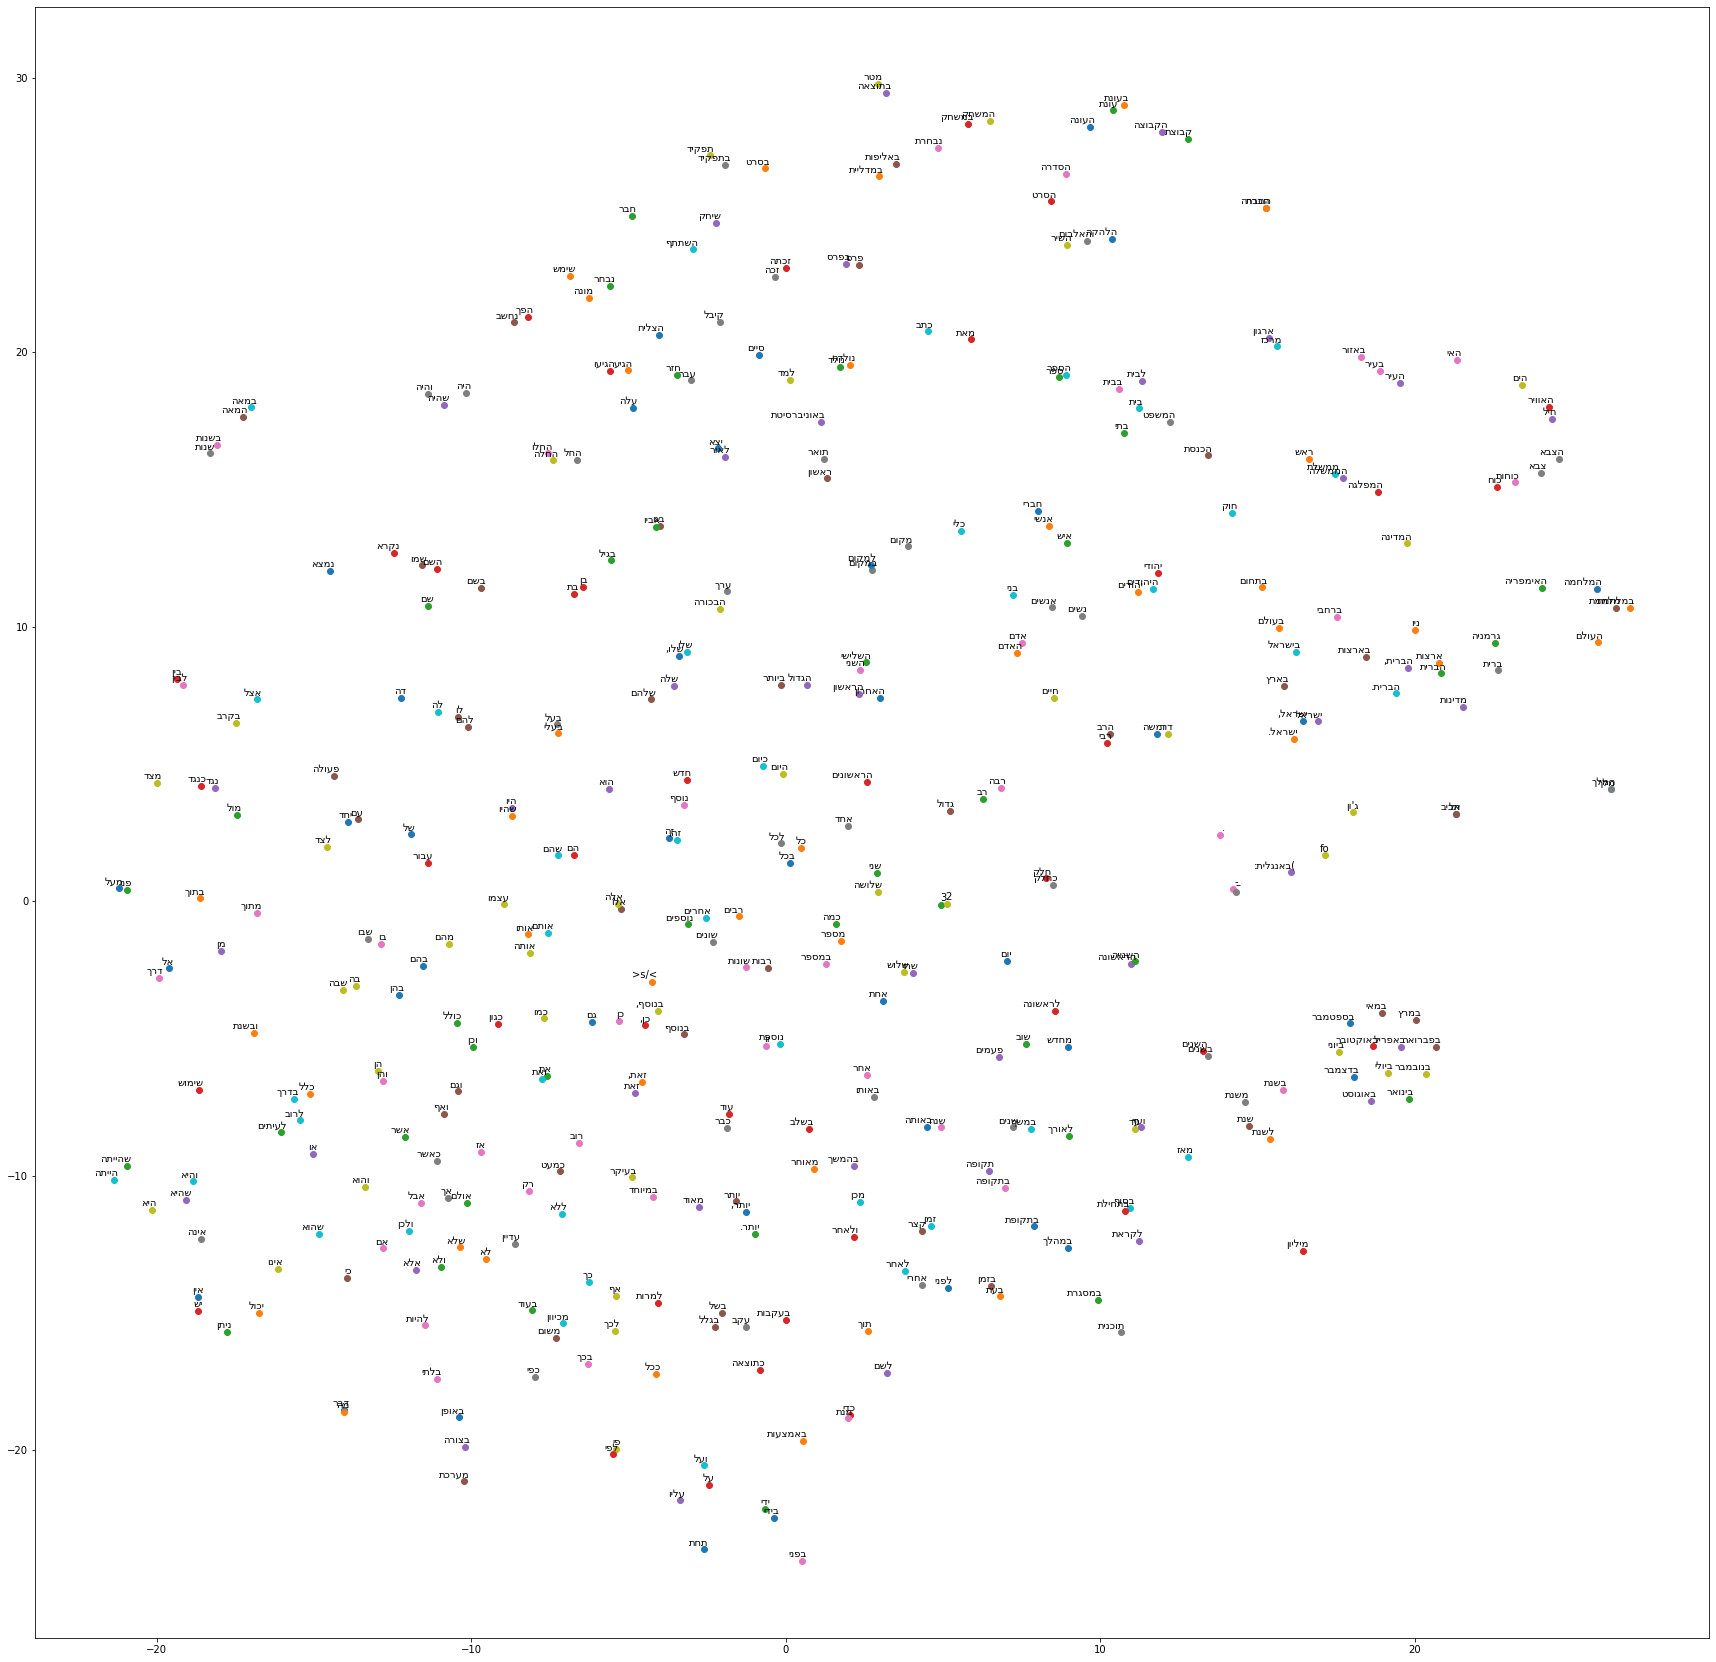

In [39]:
from matplotlib import pylab
%matplotlib inline

def plot(embeddings, labels):
    pylab.figure(figsize=(30,30))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(two_d_embeddings, reverse_labels)

Interesting observations
===================

Though t-SNE plot may look different for you, often you can observe the following:

...

In [ ]:
pip install gensim

In [82]:
import gensim
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('vectors.txt', binary=False)

In [91]:
#print(word_vectors.most_similar(positive=['גברת', 'מלך'], negative=['מר'])[0])
#print(word_vectors.most_similar(positive=['סין', 'יפנית'], negative=['יפן'])[0])
print(word_vectors.most_similar(positive=['קליעה', 'כדורגל'], negative=['שער'])[0])

('כדורסל', 0.7645145654678345)


In [92]:
word_vectors.similar_by_word('קורונה')

[('נגיף', 0.7511022090911865),
 ('SARS-CoV-2', 0.7143951654434204),
 ('(COVID-19).', 0.7097784280776978),
 ('קורונה,', 0.7015745043754578),
 ('קורונה.', 0.693303644657135),
 ('SARS-CoV-2,', 0.6792353987693787),
 ('COVID-19,', 0.6672257781028748),
 ('מנגיף', 0.6655750274658203),
 ('בנגיף', 0.6607710719108582),
 ('הקורונה', 0.6595682501792908)]

In [95]:
word_vectors.doesnt_match("קורונה איידס שפעת אפונה".split())
word_vectors.doesnt_match("פעמון כונן מסך מקלדת".split())
word_vectors.doesnt_match("סטארק לניסטר קלגיין נחום".split())

'נחום'

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sess.delete_endpoint(bt_endpoint.endpoint)